In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import ase 
from ase.units import Bohr 
import torch
import metatensor
from metatensor import TensorMap, TensorBlock, Labels
import matplotlib.pyplot as plt
from ase.io import read 
import warnings 

from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import * 
from mlelec.models.linear import LinearModelPeriodic
from mlelec.features.acdc import *



In [25]:
kmesh = [4,4,1]
filename = "C2_rotated"
frames = read('C2_rotated.xyz', ':') # will be automated 
# frames = read('examples/data/periodic/c2/C2_174.extxyz', ':10')
for f in frames:
    f.pbc = [True, True, True]
desired_shifts1 = [[0,0,0], [1,0,0]]
kfock = np.load('examples/data/periodic/c2/results_{}/kfocks.npy'.format(filename))
rotated_dataset = PySCFPeriodicDataset(frames = frames, kgrid=kmesh, matrices_kpoint = kfock, target=["real_translation"] ,device = "cuda", desired_shifts=desired_shifts1)

In [27]:
# # test 
reconstruct_k = rotated_dataset.get_kpoint_target(rotated_dataset.matrices_translation)
# torch.linalg.norm(torch.stack(reconstruct_k[:]).cpu() - kfock[:])

IndexError: list index out of range

In [16]:
rotated_dataset.matrices_translation.keys()

dict_keys([(0, 0, 0), (0, 1, 0), (0, 2, 0), (0, 3, 0), (1, 0, 0), (1, 1, 0), (1, 2, 0), (1, 3, 0), (2, 0, 0), (2, 1, 0), (2, 2, 0), (2, 3, 0), (3, 0, 0), (3, 1, 0), (3, 2, 0), (3, 3, 0)])

## Target

In [28]:
## This should happen in the ML Dataset class #TODO
## Fix orbital order 
from mlelec.utils.twocenter_utils import fix_orbital_order
orbs = {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1], [2,1,0]]}
for T in rotated_dataset.desired_shifts: #matrices_translation.keys():
    T = tuple(T)
    rotated_dataset.matrices_translation[T] = fix_orbital_order(rotated_dataset.matrices_translation[T], frames, orbs)

In [24]:
desired_shifts = [list(x) for x in rotated_dataset.desired_shifts]
desired_shifts.remove([0,0,0]) # for now we remove the zero shift until i have incorporate featuires for zero shift into the feats 

## Matrix to blocks 

In [29]:
from mlelec.utils.twocenter_utils import _to_blocks, _to_matrix, _to_coupled_basis, _to_uncoupled_basis, discard_nonhermiticity

In [30]:
# Extracting matrices out from the dataset for now 
matrices = {}
for s in rotated_dataset.desired_shifts[:]: # positive translations only 
    matrices[tuple(s)] = rotated_dataset.matrices_translation[tuple(s)]
    # NORMALIZING the translated matrices for each structure - not sure this is for training - SKIP if not needed
    # matrices[tuple(s)] = matrices[tuple(s)]/torch.linalg.norm(matrices[tuple(s)], axis = (1,2) ) [:,None, None]


In [31]:
target_blocks = {}
target_blocks = {}
target_coupled_blocks = {}
for s in rotated_dataset.desired_shifts[:]:
    target_blocks[tuple(s)] = _to_blocks(matrices[tuple(s)], frames=frames, orbitals=orbs, NH=True) # matrix -> uncoupled
    # Dont forget NH = True
    target_coupled_blocks[tuple(s)] = _to_coupled_basis(target_blocks[tuple(s)], orbs, skip_symmetry=True) # uncouple -> coupled
    # Dont forget skip_symmetry = True
from collections import defaultdict
blocks = []
tmap_keys = []
for translation in target_coupled_blocks.keys():
    for i, (key, block) in enumerate(target_coupled_blocks[translation].items()):
        blocks.append(block.copy())
        x = list(key)
        x.extend(translation)
        tmap_keys.append(x)
keys = Labels(next(iter(target_coupled_blocks.values())).keys.names+["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.asarray(tmap_keys))
target = TensorMap(keys=keys, blocks=blocks)

target = target.keys_to_samples('cell_shift_a')
target = target.keys_to_samples('cell_shift_b')
target = target.keys_to_samples('cell_shift_c')


/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/mlelec/utils/twocenter_utils.py:162: UserWarning: Matrix is neither hermitian nor antihermitian - attempting to use _toblocks for NH
  warnings.warn(


## feature

In [32]:
from mlelec.utils.metatensor_utils import labels_where
from metatensor import Labels
from mlelec.features.acdc import twocenter_hermitian_features, single_center_features, pair_features, twocenter_hermitian_features_periodic
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
from mlelec.features.acdc import twocenter_features_periodic_NH
from mlelec.features.acdc_utils import _pca, block_to_mic_translation


In [33]:
hypers = {'cutoff': 4,
          'max_radial': 8, 
          'max_angular': 4,
          'atomic_gaussian_width':0.3,
          'center_atom_weight': 1,
          "radial_basis": {"Gto": {}},
          "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
          "radial_scaling": 
}

In [34]:
calculator = PairExpansion(**hypers)
rho0_ij = calculator.compute(frames)
rho0_ij = fix_gij(rho0_ij)
rho0_ij = acdc_standardize_keys(rho0_ij)

In [35]:
rhoij = pair_features(frames, hypers, order_nu=[1,1],  all_pairs=True, lcut=2, max_shift=[3,3,1], both_centers=True,mic = True, kmesh = kmesh, desired_shifts=desired_shifts[:])# device = "cpu")
# SLOW as labels_where is super slow (used to find the valus idx of mic )

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/mlelec/features/acdc.py:136: UserWarning: Using cutoff 9.0 for all pairs feature
  warnings.warn(
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/mlelec/features/acdc.py:151: UserWarning: Using kmesh [4, 4, 1] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")
/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/mlelec/utils/pbc_utils.py:39: UserWarning: J is greater than the number of atoms in the supercell. Mapping J to J % len(superframe)
  warnings.warn(


In [36]:
hfeat = twocenter_features_periodic_NH(single_center=None, pair= rhoij) # take the pair feature and create features corresponding to different blocks of the hamiltonian 

In [37]:
# Compute features that will be used for the [000] translation 
rhonui = single_center_features(frames, hypers, order_nu=3, lcut=2, max_shift=[2,3,1], feature_names = hfeat.property_names)
rhoij_zero_shift = pair_features(frames, hypers, order_nu=[1,1],  both_centers=True, all_pairs=True, lcut=2, max_shift=[1,1,1], feature_names = rhonui.property_names)
# pair = rhoij
blocks = []
for i, (key, block) in enumerate(rhoij_zero_shift.items()):
    samples_lab, idx = labels_where(block.samples, selection=Labels(["cell_shift_a", "cell_shift_b", "cell_shift_c"], values=np.asarray([[0,0,0]]).reshape(-1, 3)), return_idx=True)
    samples_lab =  Labels(samples_lab.names[:3], values=samples_lab.values[:,:3])
    tb = TensorBlock(
        samples=samples_lab,
        values=block.values[idx],
        properties=block.properties,
        components = block.components
    )
    blocks.append(tb)
rhoij_zero_shift = TensorMap(keys = rhoij_zero_shift.keys, blocks=blocks)
hfeat0 = twocenter_features_periodic_NH(single_center= rhonui, pair = rhoij_zero_shift, shift=[0,0,0]) # take the pair feature and create features corresponding to different blocks of the hamiltonian
hfeat0 = hfeat0.keys_to_samples('cell_shift_a')
hfeat0 = hfeat0.keys_to_samples('cell_shift_b')
hfeat0 = hfeat0.keys_to_samples('cell_shift_c')
hfeat0 = hfeat0.keys_to_samples('cell_shift_a_MIC')
hfeat0 = hfeat0.keys_to_samples('cell_shift_b_MIC')
hfeat0 = hfeat0.keys_to_samples('cell_shift_c_MIC')

hfeat0.property_names == hfeat.property_names
from metatensor.operations import join 
hfeat = join([hfeat, hfeat0],axis="properties")

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/mlelec/features/acdc.py:136: UserWarning: Using cutoff 2.0 for all pairs feature
  warnings.warn(


## train

In [38]:
from mlelec.models.linear import LinearModelPeriodic
from mlelec.utils.plot_utils import plot_hamiltonian 

In [121]:
model = LinearModelPeriodic(hfeat, target, frames, orbs,
                            cell_shifts= rotated_dataset.desired_shifts[:], 
                            nhidden=16, nlayers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)


def train(model, target_blocks, nepochs=10, optimizer=None, scheduler=None, log_interval=10):
    losses = []
    for i in range(nepochs):
        # def closure():
        #     optimizer.zero_grad()
        #     rmat = model.forward()
        #     loss = 0
        #     for s in rmat:            
        #         loss += torch.linalg.norm(rmat[s]-matrices[tuple(s)])**2
        #     # loss = torch.linalg.norm(rmat - matrices)**2
        #     # loss.backward()
        #     return loss

        # optimizer.step(closure)
        # loss = closure()

    #---ADAM---- 
        optimizer.zero_grad()
        # rmat = model.forward()#return_matrix=True)
        rmat, ridges = model.fit_ridge_analytical()
        loss = 0
        for s in rmat:      
            for (key, block) in rmat[s].items():
                # loss += torch.linalg.norm(block.values-target_blocks[tuple(s)].block(key).values)**2      
                loss += np.linalg.norm(block.values-target_blocks[tuple(s)].block(key).values.cpu().numpy())**2      
            # loss += torch.sum((rmat[s]-matrices[tuple(s)])**2)


        # loss.backward()
        # optimizer.step()
        # scheduler.step(loss)
        losses.append(loss.item())
        if i%log_interval ==0:
            print(i, loss.item())
    return losses, model, optimizer, ridges


[[0, 0, 0], [1, 0, 0]] 2


In [122]:
losses, model, optimizer, ridges = train(model, target_coupled_blocks, nepochs=1, optimizer=optimizer)

0 8.951633596679936e-12


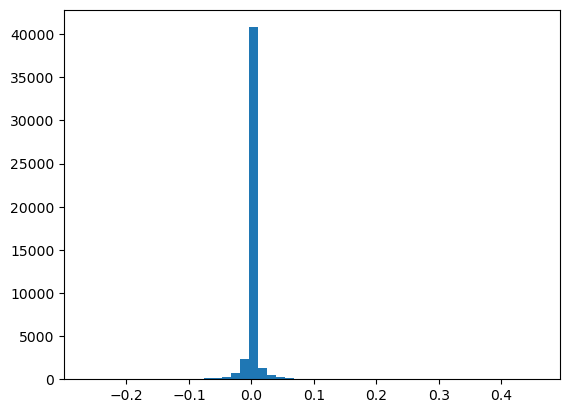

In [126]:
w = ridges[10].coef_.flatten()
# where = (w>-0.000000001) & (w<0)
where=w<1e100
plt.hist(w[where], bins=50);
# plt.xlim(-0.01,0)

In [125]:
ridges[0].alpha_

4.9238826317067315e-14

In [ ]:
plt.loglog(losses) # train between 1000-1500 epochs

In [134]:
with torch.no_grad():
    pred_trans = model.forward(return_matrix=True)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/metatensor_utils.py:129: DeviceWarning: Values and labels for this block are on different devices: labels are always on CPU, and values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorBlock`.
  block = TensorBlock(
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/utils/metatensor_utils.py:91: DeviceWarning: Blocks values and keys for this TensorMap are on different devices: keys are always on CPU, and blocks values are on device 'cuda:0'. If you are using PyTorch and need the labels to also be on cuda:0, you should use `metatensor.torch.TensorMap`.
  return TensorMap(keys, blocks)


In [135]:
for s in pred_trans.keys():
    # print(s, torch.linalg.norm(pred_trans[s]), np.linalg.norm(rotated_dataset.matrices_translation[s]))

    print(s, torch.linalg.norm(pred_trans[s]-matrices[s])/torch.linalg.norm(matrices[s]))

(0, 0, 0) tensor(0.0072, device='cuda:0', dtype=torch.float64)
(0, 1, 0) tensor(0.0068, device='cuda:0', dtype=torch.float64)
(0, 2, 0) tensor(0.0193, device='cuda:0', dtype=torch.float64)
(0, 3, 0) tensor(0.0068, device='cuda:0', dtype=torch.float64)
(1, 0, 0) tensor(0.0066, device='cuda:0', dtype=torch.float64)
(1, 1, 0) tensor(0.0077, device='cuda:0', dtype=torch.float64)
(1, 2, 0) tensor(0.0078, device='cuda:0', dtype=torch.float64)
(1, 3, 0) tensor(0.0091, device='cuda:0', dtype=torch.float64)
(2, 0, 0) tensor(0.0363, device='cuda:0', dtype=torch.float64)
(2, 1, 0) tensor(0.0083, device='cuda:0', dtype=torch.float64)
(2, 2, 0) tensor(0.0258, device='cuda:0', dtype=torch.float64)
(2, 3, 0) tensor(0.0083, device='cuda:0', dtype=torch.float64)
(3, 0, 0) tensor(0.0066, device='cuda:0', dtype=torch.float64)
(3, 1, 0) tensor(0.0091, device='cuda:0', dtype=torch.float64)
(3, 2, 0) tensor(0.0138, device='cuda:0', dtype=torch.float64)
(3, 3, 0) tensor(0.0077, device='cuda:0', dtype=torch.f

## check if model prediction is periodic cause of the features 

In [68]:
model = LinearModelPeriodic(hfeat, target, frames, orbs,
                            cell_shifts= rotated_dataset.desired_shifts[:], 
                            nhidden=16, nlayers=2)


[[0, 0, 0], [0, 1, 0], [0, 2, 0], [0, 3, 0], [1, 0, 0], [1, 1, 0], [1, 2, 0], [1, 3, 0], [2, 0, 0], [2, 1, 0], [2, 2, 0], [2, 3, 0], [3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 3, 0]] 16


In [71]:
with torch.no_grad():
    for i,layer in enumerate(model.state_dict()):

            model.state_dict()[layer].data.fill_(1)


In [72]:
with torch.no_grad():
    pred = model.forward(return_matrix=True)

In [73]:
for s in pred.keys():
    print(s, torch.linalg.norm(pred[s]), np.linalg.norm(rotated_dataset.matrices_translation[s]))

(0, 0, 0) tensor(25122.8691, device='cuda:0') 29.720349537789836
(0, 1, 0) tensor(5529.4873, device='cuda:0') 3.8037288618074836
(0, 2, 0) tensor(2296.3838, device='cuda:0') 0.12872204223361142
(0, 3, 0) tensor(5529.4873, device='cuda:0') 3.8037288618074827
(1, 0, 0) tensor(3613.4426, device='cuda:0') 1.3779133823860996
(1, 1, 0) tensor(5575.9629, device='cuda:0') 3.932570701492888
(1, 2, 0) tensor(2600.2625, device='cuda:0') 0.3638213945858173
(1, 3, 0) tensor(2190.1235, device='cuda:0') 0.11316362926982403
(2, 0, 0) tensor(1847.7928, device='cuda:0') 0.02269577960334376
(2, 1, 0) tensor(2194.8967, device='cuda:0') 0.11873927294939798
(2, 2, 0) tensor(2353.3105, device='cuda:0') 0.143857100848483
(2, 3, 0) tensor(2194.8967, device='cuda:0') 0.11873927294939723
(3, 0, 0) tensor(3613.4426, device='cuda:0') 1.3779133823861014
(3, 1, 0) tensor(2190.1235, device='cuda:0') 0.1131636292698239
(3, 2, 0) tensor(2651.7317, device='cuda:0') 0.3638213945858177
(3, 3, 0) tensor(5575.9629, device='

In [100]:
feat_norm = [torch.linalg.norm(pred[s]).detach().cpu().numpy() for s in rotated_dataset.desired_shifts]
mat_norm = [(torch.linalg.norm(pred_trans[s]-torch.from_numpy(rotated_dataset.matrices_translation[s]).to('cuda'))/torch.linalg.norm(torch.from_numpy(rotated_dataset.matrices_translation[s]).to('cuda'))).detach().cpu().numpy() for s in rotated_dataset.desired_shifts] 


-2.375991518022842


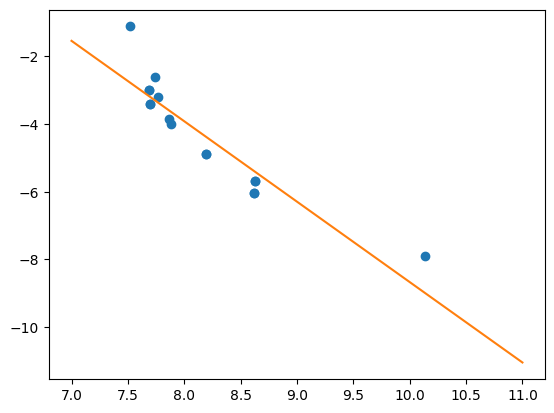

In [111]:

plt.plot(np.log(feat_norm), np.log(mat_norm),'o')# ls='')
# plt.yscale('log')
from scipy.optimize import curve_fit
popt,pcov=curve_fit(lambda x, m, q: m*x+q, np.log(feat_norm), np.log(mat_norm))    
x=np.linspace(7,11)
m,q=popt
plt.plot(x, m*x+q)
print(m)

## reconstruct k-point target 

In [357]:
matrices_translation = model.forward(return_matrix=True)
pred_kpts = rotated_dataset.get_kpoint_target(matrices_translation)


In [358]:
Nk = np.prod(kmesh )
for kpt in range(Nk):
    print(kpt, torch.linalg.norm(pred_kpts[kpt] - rotated_dataset.matrices_kpoint[kpt]))
# torch.linalg.norm(recons_kpt_target - small_shifts_target)

0 tensor(0.0027, dtype=torch.float64)
1 tensor(0.0027, dtype=torch.float64)
2 tensor(0.0028, dtype=torch.float64)
3 tensor(0.0027, dtype=torch.float64)
4 tensor(0.0041, dtype=torch.float64)
5 tensor(0.0040, dtype=torch.float64)
6 tensor(0.0041, dtype=torch.float64)
7 tensor(0.0042, dtype=torch.float64)
8 tensor(0.0028, dtype=torch.float64)
9 tensor(0.0027, dtype=torch.float64)
10 tensor(0.0027, dtype=torch.float64)
11 tensor(0.0027, dtype=torch.float64)
12 tensor(0.0041, dtype=torch.float64)
13 tensor(0.0042, dtype=torch.float64)
14 tensor(0.0041, dtype=torch.float64)
15 tensor(0.0040, dtype=torch.float64)


## Train on kpoint matrices

In [41]:
model = LinearModelPeriodic(hfeat, target, frames, orbs,
                            cell_shifts= rotated_dataset.desired_shifts[:], 
                            nhidden=16, nlayers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer= torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.LBFGS(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)


def train_kpoint(model, target_blocks, nepochs=10, optimizer=None, scheduler=None, log_interval=10):
    losses = []
    for i in range(nepochs):
        # def closure():
        #     optimizer.zero_grad()
        #     rmat = model.forward()
        #     loss = 0
        #     for s in rmat:            
        #         loss += torch.linalg.norm(rmat[s]-matrices[tuple(s)])**2
        #     # loss = torch.linalg.norm(rmat - matrices)**2
        #     # loss.backward()
        #     return loss

        # optimizer.step(closure)
        # loss = closure()

    #---ADAM---- 
        optimizer.zero_grad()
        rmat = model.forward(return_matrix=True)
        rkmat = torch.stack(rotated_dataset.get_kpoint_target(rmat))
        
        loss = 0
        loss += torch.linalg.norm(rkmat - rotated_dataset.matrices_kpoint)**2

        # constrain loss by adding addition loss terms on translated matrices
        # for s in [tuple([0,0,0]), tuple([1,0,0])]:     
        #     loss += torch.sum((rmat[s]-matrices[tuple(s)])**2)


        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        losses.append(loss.item())
        if i%log_interval ==0:
            print(i, loss.item())
    return losses, model, optimizer

[[0 0 0]
 [0 1 0]
 [0 2 0]
 [0 3 0]
 [1 0 0]
 [1 1 0]
 [1 2 0]
 [1 3 0]
 [2 0 0]
 [2 1 0]
 [2 2 0]
 [2 3 0]
 [3 0 0]
 [3 1 0]
 [3 2 0]
 [3 3 0]] 16


In [42]:
losses, model, optimizer = train_kpoint(model, target_coupled_blocks, nepochs=200, optimizer=optimizer)

0 15156.965686043211
10 14901.350436971601
20 14479.774295662553
30 13835.510535991945
40 12928.797914094568
50 11756.922435085986
60 10368.003279744344
70 8832.843967593217
80 7218.668691068899
90 5576.884890700811
100 3971.2156237910503
110 2566.2282247762514
120 1560.7927607787049
130 1027.8432305594301
140 854.3761617266298
150 832.4936031269673
160 827.8448189714267
170 815.3369704889398
180 803.4761517198482
190 794.2529210163812


KeyboardInterrupt: 

In [35]:
rmat = model.forward(return_matrix=True)
rkmat = torch.stack(rotated_dataset.get_kpoint_target(rmat))

In [38]:
rkmat

tensor([[[[-6.1536e-02+0.0000e+00j, -7.9974e-02+0.0000e+00j,
            7.8433e-04+0.0000e+00j,  ...,
           -5.8546e-02+0.0000e+00j,  0.0000e+00+0.0000e+00j,
            3.7080e-03+0.0000e+00j],
          [-7.3813e-02+0.0000e+00j, -8.2722e-02+0.0000e+00j,
            2.4404e-03+0.0000e+00j,  ...,
           -2.8483e-02+0.0000e+00j,  0.0000e+00+0.0000e+00j,
            1.7138e-03+0.0000e+00j],
          [-2.5424e-03+0.0000e+00j,  2.9417e-03+0.0000e+00j,
            1.1119e-02+0.0000e+00j,  ...,
           -5.6882e-02+0.0000e+00j,  0.0000e+00+0.0000e+00j,
            9.2472e-04+0.0000e+00j],
          ...,
          [-5.5140e-02+0.0000e+00j, -4.6563e-02+0.0000e+00j,
           -5.5349e-02+0.0000e+00j,  ...,
            1.0591e-02+0.0000e+00j,  0.0000e+00+0.0000e+00j,
            6.3796e-04+0.0000e+00j],
          [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
            0.0000e+00+0.0000e+00j,  ...,
            0.0000e+00+0.0000e+00j, -1.1077e-01+0.0000e+00j,
            0.000

In [22]:
rmat[0,0,0].shape

torch.Size([3, 10, 10])

## band structure

In [374]:
overlaps_k = []
for i in range(len(frames)):
    s = np.load('examples/data/periodic/c2/results_C2_rotated/unitcell/unitcell_over_{}.npy'.format(i))
    sk=[]
    for k in range(s.shape[0]):
        sk.append(fix_orbital_order(s[k], frames[i], orbs))
    overlaps_k.append(np.asarray(sk))

In [377]:
recons_kpt_target.shape

torch.Size([16, 3, 10, 10])

In [393]:
kpts

array([[ 0.        ,  0.        ,  0.        ],
       [-0.23126954,  0.34712315, -0.02190167],
       [-0.46253907,  0.6942463 , -0.04380333],
       [-0.69380861,  1.04136945, -0.065705  ],
       [ 0.18718375,  0.38441623,  0.02943425],
       [-0.04408578,  0.73153938,  0.00753258],
       [-0.27535532,  1.07866253, -0.01436909],
       [-0.50662486,  1.42578568, -0.03627075],
       [ 0.37436751,  0.76883247,  0.05886849],
       [ 0.14309797,  1.11595562,  0.03696683],
       [-0.08817157,  1.46307877,  0.01506516],
       [-0.3194411 ,  1.81020192, -0.0068365 ],
       [ 0.56155126,  1.1532487 ,  0.08830274],
       [ 0.33028172,  1.50037185,  0.06640107],
       [ 0.09901219,  1.847495  ,  0.04449941],
       [-0.13225735,  2.19461815,  0.02259774]])

In [440]:
import scipy
eva = []
eva_actual = []
kkfock = np.load('examples/data/periodic/c2/results_{}/unitcell/unitcell_fock_{}.npy'.format('C2_rotated', 0))

for k in range(Nk):
    band_all_ =[]
    band_all_actual = []
    for f in range(len(frames)):
        Hk = recons_kpt_target[k,f]
        Sk = overlaps_k[f,k]
        band_all_.append(scipy.linalg.eigvalsh(Hk, Sk)*27.2)
        band_all_actual.append(scipy.linalg.eigvalsh(kkfock[k], Sk)*27.2)
    eva.append(band_all_)
    eva_actual.append(band_all_actual)
    # Hk = recons_kpt_target[k]
    # Sk = overlaps_k[:,k]
    # eva.append(scipy.linalg.eigvalsh(Hk, Sk)*27.2)
eva = np.array(eva)
eva_actual = np.array(eva_actual)
# print(eva.shape)

In [420]:
from ase.dft.kpoints import ibz_points, get_bandpath

path = get_bandpath(kpts_scaled, frame.cell, npoints=Nk)

In [441]:
eva.shape, eva_actual.shape

((16, 3, 10), (16, 3, 10))

In [422]:
x2, X2, labels = path.get_linear_kpoint_axis()
labels = [label.replace('G', '\Gamma') for label in labels]

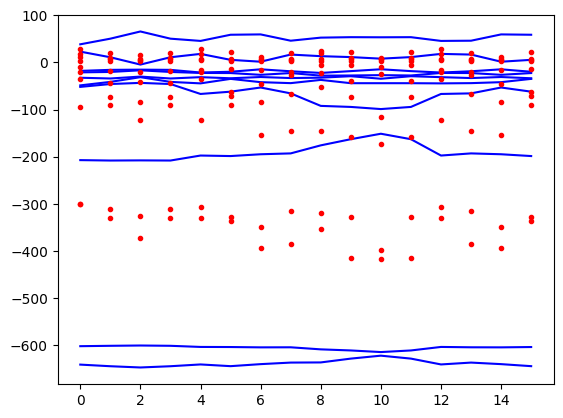

In [444]:
nkpoints = int(Nk / (len(labels) - 1))
x1 = list(range(Nk))
# X1 = [x1[0]] + x1[nkpoints - 1::nkpoints]

# plt.xticks(X1, ['$%s$' % n for n in labels])

# Create plot
for iband in range(nao):
    band = eva[:, 0, iband] 
    plt.plot(x1, band, color='b')

    # Change range:
    # plt.ylim(ylim)
    
for iband in range(nao):
    band = eva_actual[:, 0, iband] 
    plt.plot(x1, band, color='r', ls = '', marker = '.')

In [418]:
hunit = frames[0].cell
v = np.linalg.det(hunit)
kh = np.array([
    np.cross(hunit[1],hunit[2])*2*np.pi/v,
    np.cross(hunit[2],hunit[0])*2*np.pi/v,
    np.cross(hunit[0],hunit[1])*2*np.pi/v,
])
kpts[:,:2]/kh[0][:2]

array([[ 0.        ,  0.        ],
       [-0.0824324 ,  0.21430091],
       [-0.16486481,  0.42860182],
       [-0.24729721,  0.64290273],
       [ 0.06671872,  0.23732427],
       [-0.01571369,  0.45162518],
       [-0.09814609,  0.6659261 ],
       [-0.1805785 ,  0.88022701],
       [ 0.13343743,  0.47464855],
       [ 0.05100503,  0.68894946],
       [-0.03142737,  0.90325037],
       [-0.11385978,  1.11755128],
       [ 0.20015615,  0.71197282],
       [ 0.11772375,  0.92627373],
       [ 0.03529134,  1.14057464],
       [-0.04714106,  1.35487555]])

In [394]:
eva.shape

(16, 3, 10)

In [388]:
eva.shape

(16, 3, 10)

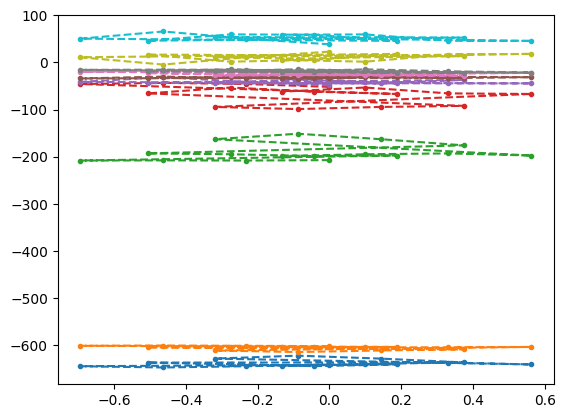

In [407]:
# for i in range(eva.shape[2]):
#     plt.plot(range(10), eva[i,0,:])
# plt.ylim(-15,18)
for b in range(nao):
    plt.plot(kpts[:,0], eva[:,0,b], marker='.', ls='--')

In [392]:
qgrid = np.linspace(0,0.5,20)
kgrid = [kh[0] * x for x in qgrid]

NameError: name 'kh' is not defined

In [ ]:
model = LinearModelPeriodic(feat_plus, feat_minus, target_coupled_blocks_sum, target_coupled_blocks_diff, desired_shifts, frames, orbs, nhidden=16, nlayers=2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=100, verbose=True)
losses = []
for i in range(300):
    optimizer.zero_grad()
    rsum, rdiff = model.forward()
    loss = loss_fn_combined(rsum, rdiff, expkL_small, small_shifts_target)
    loss.backward()
    optimizer.step()
    # scheduler.step(loss)
    losses.append(loss.item())
    if i%10 ==0:
        print(loss.item())

0.16023802757263184
0.031491734087467194
0.009251020848751068
0.003096561646088958
0.0009399798000231385
0.0004689812776632607
0.00024364719865843654
0.00017960922559723258
0.00014655283303000033
0.00012858735863119364
0.0001240893907379359
0.00012232616427354515
0.00012163409701315686
0.00012134024291299284
0.00012129032984375954
0.00012125116336392239
0.00012124008208047599
0.00012123619671911001
0.00012123472697567195
0.0001212342904182151
0.00012123407941544428
0.00012123402848374099
0.00012123401393182576
0.00012123399937991053


KeyboardInterrupt: 

# Scaling test 

## Repeat

In [120]:
repeat = read('examples/data/periodic/c2/C2_repeated.extxyz', ':')
expand = read('examples/data/periodic/c2/C2_expanded_cell.extxyz', ':')
uc = read('examples/data/periodic/c2/C2_rotated.xyz', ':')

In [132]:
relative_Ls = []
uc_idx = np.arange(3)
for i in range(0,3,3):#(0,len(repeat),3):
    for 
    for ij, j in enumerate(range(i, i+3)):
        print(i, j, ij)
        
        print(repeat[i].cell/uc[ij].cell)


0 0 0
[[ 1. nan nan]
 [ 1.  1. nan]
 [nan nan  1.]]
0 1 1
[[ 1.28162018  0.          0.        ]
 [ 0.53660548  2.38742943  0.        ]
 [-0.         -0.          1.00107327]]
0 2 2
[[ 1.21359767  0.          0.        ]
 [ 0.56084457  1.96032697 -0.        ]
 [-0.         -0.          1.00746103]]


/tmp/ipykernel_9552/3657698193.py:5: RuntimeWarning: invalid value encountered in divide
  print(repeat[i].cell/uc[ij].cell)


In [122]:
[f.cell for f in uc]

[Cell([[2.239543, 0.0, 0.0], [-1.14898, 1.990093, 0.0], [0.0, 0.0, 106.227097]]),
 Cell([[1.7474311340791573, 1.3989869746088026, 0.06980490938850882], [-2.141200661866938, 0.8335714459019969, 0.032304167632637014], [-0.30970941332333385, -4.907856331246132, 106.11320918414707]]),
 Cell([[1.845375159791643, 1.2449581433211754, 0.24540291329008204], [-2.0486603036546174, 1.0151842156847792, -0.23025454936493506], [-12.770098697549846, -1.855290633905602, 105.44040313355212]])]

In [ ]:
blocks = []
dist = [f.get_all_distances() for f in repeat]

keys = Labels(["species_i", "species_j", "tx", "ty", "tz" ])
for i, f in enumerate(repeat):
    d = dist[i]
    for j in range(len(f)):
        for k in range(len(f)):
            blocks.append(TensorBlock(values = d[j,k]. 
                                      properties = 
                                      components= 
                                      samples =))
                blocks.append(TensorBlock(values = dist[j,k], keys = keys, components = Labels(["distance"])))

## Extend